# **Mini challenge: Copy-move image forgery detection**

Course: ImSecu Fall 2021

Supervisors: Alexandre BERTHET, Dr. Chiara GALDI, Prof. Jean-Luc DUGELAY

In [1]:
!git clone https://github.com/s273871/ImSecu.git

fatal: destination path 'ImSecu' already exists and is not an empty directory.




---


**Student name:** Paolo D'Ambrosio

**Student email:** paolo.dambrosio@eurecom.fr


---



**Introduction**

This mini challenge is aimed at familiarise you  with image forgery detection techniques. You will also learn how to assess the accuracy of detection using some dedicated metrics. You will be provided with a set of images and asked to identify which images have been manipulated and to locate the forged areas. To do so, you need to complete a code for forgery detection and use it on the images.

Figure 1: example of copy-move image forgery.

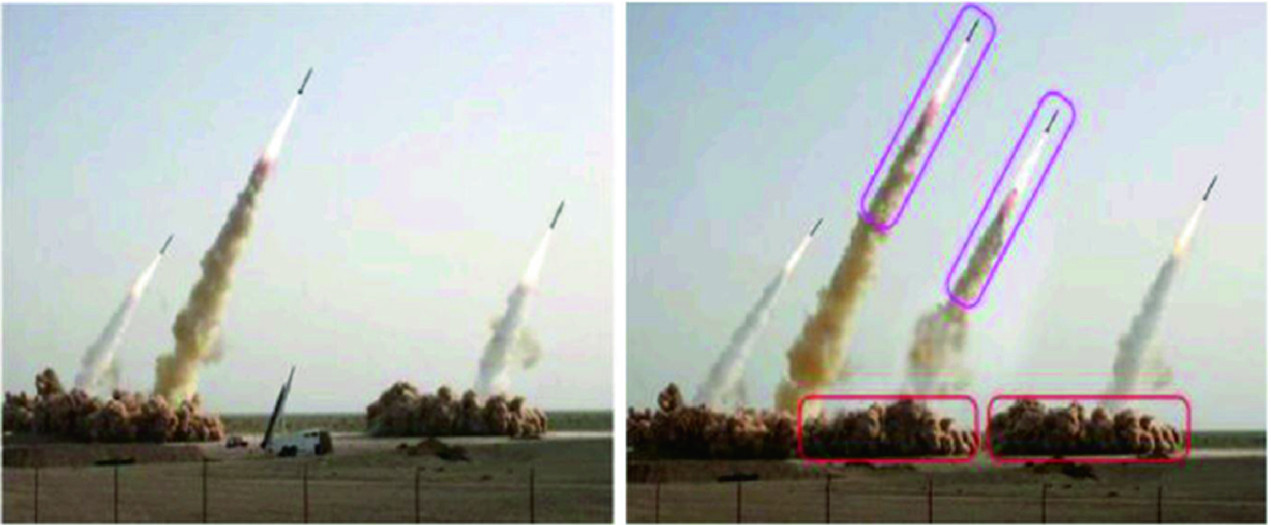


**Objective**
The objective of the challenge is to develop and test a technique for *copy-move* detection based on Discrete Cosine Transform (DCT) analysis.

**Copy move:** a copy-move forgery is created by copying and pasting content *within the same image*. See an example in Figure 1 above.


**Protocol:** A python implementation of a copy-move detector is available in the following. The notebook is made of several parts that correspond to the steps of the detector described below. You have to fill in the notebook to create the detector. At the end of the notebook, there is a short script to evaluate the accuracy of the detector from the ground-truth and prediction mask that you will create.

After completing the code, the performance of your detector is evaluated in two ways:

*  **The validation**: to supervise your implementation and verify that your detector is reaching the desired performance. For this purpose, you will have 3 images (2 manipulated and 1 non-manipulated) with their ground-truth and prediction masks. Thanks to this dataset, you will be able to compare your prediction mask to the ground truth to evaluate your detector. In this phase, the prediction mask obtained with our implementation is also provided to you as a baseline to let you know what is the target performance to reach. 

  **WARNING**: please notice that the accuracy of the detection might not reach 1 (maximum). This is normal as the detector can have false positive and false negative detections.

*   **The test**: to evaluate your final detector. This evaluation will be conducted blindly: you cannot verify the performance of your detector and you have to provide the prediction mask to us. We will then compare your prediction masks with the ground truths. For this purpose, you will have 5 images with no information (label, ground-truth) to pass through your detector. The 5 prediction masks will permit to evaluate the performance of your detector.

**What to submit:** the python notebook (.ipynb file) with your modifications, your name and email (see top of document); the prediction masks (JPEG file) named with the name of the input image followed by "_prediction_mask" (e.g. Image1_prediction_mask), for each image in the test set.

**How to submit:** upload a zip file on Moodle.



Figure2: Flowchart of the DCT-based copy-move detection method.

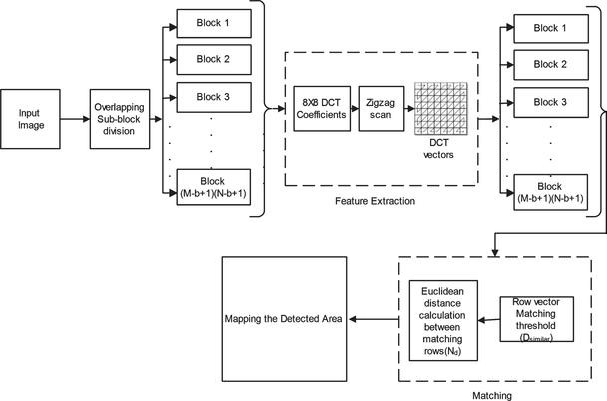

**Copy-move forgery detection using DCT**

*   Scan the image from the upper left corner to the lower right corner while sliding a *BxB* block.
*   Calculate the DCT for each block.
*   Quantize the DCT coefficients of each block and store them as a row in matrix *A*.
  *   The quatization is calculated with a user-specified parameter *Q*.
  *   Too low values of Q may produce more matching blocks, possibly some false matches.
*   Lexicographically sort the rows of *A*.
*   If two consecutive rows (i.e. blocks) in the the sorted vector *A* are found to be similar, store the position of the matching blocks in a separate list.
*   Let (i_1,i_2) and (j_1,j_2) be the positions o the two matching blocks
*   The shift vector *S* between the two matching blocks is calculated as s = (s_1, s_2) = (i_1 - j_1, i_2 - j_2).
*   The shift vector -S and S correspond to the same shift, thus shift vectors S are normalized --  *abs(S)* -- so that S >= 0.
*   For each matching pair of blocks, increment the corresponding normalized shift vector counter *C* by one: C(s_1, s_2) = C(s_1, s_2) + 1.
  *   The shift vector counter *C* is initialized to zero.
  *   The counter *C* indicates the frequencies with which normalized shift vectors occur.
*   Find all normalized shift vectors S, whose occurrence exceed a user-specified threshold *T: C(S(r)) > T* for all *r = 1, 2, ..., K*.
  *   Too large values of *T* may cause the algorithm to miss some not-so-closely matching blocks, while too small values of *T* may introduce too many false matches.
*   Look at the mutual positions of each matching block pair and output a specific block pair only if there are other matching pairs in the same mutual positions.
*   For all normalized shift vectors, the matching blocks that contributed to that specific shift vector are colored in white while the rest of the image is colored in black in order to create the predicted detection mask. The white areas identify the segment that might have been copied and moved.

A flowchart of the DCT forgery detection method is given in Figure 2 above.

**Q**: quantization value

**A**: DCT coefficient matrix

**S**: shift vector

**C**: shift vector counter

**T**: shift vector counter threshold



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


## INITIALIZATION ##
Q = 16 # quantization value
similarity_threshold = 5 # Euclidean distance block similarity threshhold
distance_threshold = 20 # Euclidean distance between pixels threshold
T = 20 # shift vector counter limit
block_counter = 0
block_size = 8 # DCT block size
resize_dim = (256, 256)

############# EDIT HERE #############
## read the input image
image = cv2.imread("/content/ImSecu/ValidationSet/image103_manipulated.jpg")
############# EDIT END #############

# the image size is reduced, if needed, to reduce the computation time
width, height, channels = image.shape
if width > 256 | height > 256:
    image = cv2.resize(image, resize_dim, interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
temp = []
arr = np.array(gray)
prediction_mask = np.zeros((arr.shape[0], arr.shape[1]))
column = arr.shape[1] - block_size
row = arr.shape[0] - block_size
A = np.empty((((column+1)*(row+1)), Q+2)) # DCT coefficient matrix


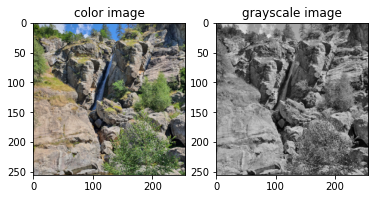

In [3]:
## PLOT THE ORIGINAL AND GRAYSCALE VERSION OF THE INPUT IMAGE

fig, axs = plt.subplots(1, 2)
axs[0].set_title('color image')
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

axs[1].set_title('grayscale image')
axs[1].imshow(gray, cmap='gray', vmin=0, vmax=255)

plt.show()

**Figure** 3: Zigzag scan illustration.

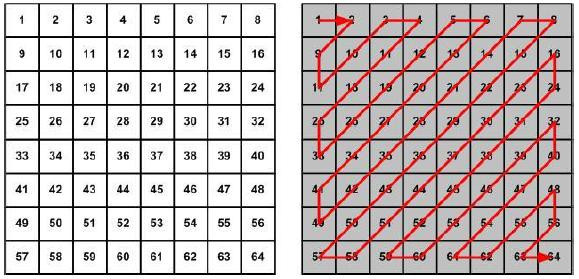

In [4]:
## COMPUTE THE DCT BLOCKS AND STORE THEM IN A

print("DCT scanning starting...")

for i in range(0, row):
    for j in range(0, column):

        blocks = arr[i:i+block_size, j:j+block_size]
        imf = np.float32(blocks) / 255.0  # float conversion/scale
        ############# EDIT HERE #############
        ## compute image DCT using opencv
        img_DCT = cv2.dct(imf)
        ############# EDIT END #############
        blocks = np.uint8(np.float32(img_DCT) * 255.0 ) # convert back
        # zigzag DCT scan. See illustration in Figure 3 above.
        solution = [[] for k in range(block_size + block_size - 1)]
        for k in range(block_size):
            for l in range(block_size):
                sum = k + l
                if (sum % 2 == 0):
                    ############# EDIT HERE #############
                    ## add at beginning of the list
                    solution[sum].insert(0,blocks[k][l]) 
                    ############# EDIT END #############
                else:
                    ############# EDIT HERE #############
                    ## add at end of the list
                    solution[sum].append(blocks[k][l])
                    ############# EDIT END #############
        
        # only the 16 most significant coefficients are selected
        for item in range(0,(block_size*2-1)): 
            temp += solution[item]

        temp = np.asarray(temp, dtype=np.float)
        temp = np.array(temp[:16])
        ############# EDIT HERE #############
        ## quatize the values
        temp = np.divide(temp, Q).astype(int)
        ############# EDIT END #############
        temp = np.append(temp, [i, j]) # the block coordinates are appended at the end
        
        # Store the DCT block in A
        np.copyto(A[block_counter], temp)

        block_counter += 1
        temp = []

print("DCT scanning over!")

DCT scanning starting...
DCT scanning over!


In [5]:
## LEXICOGRAPHICALLY SORT the rows of A

print("lexicographic sorting starting...")

A = A[~np.all(A == 0, axis=1)]
A = A[np.lexsort(np.rot90(A))]

print("lexicographic sorting over!")

lexicographic sorting starting...
lexicographic sorting over!


In [6]:
## LOOK FOR MATCHING BLOCKS

print("euclidean operations starting...")

sim_array = []
for i in range(0, block_counter):
    if i <= block_counter-10:
        for j in range(i+1, i+10):
            ############# EDIT HERE #############
            ## compute the similarity between two blocks (Euclidean distance of the two coefficient vectors)
            pixelsim = np.linalg.norm(A[i][:16]-A[j][:16])
            ## compute the Euclidean distance between the blocks' coordinates
            pointdis = np.linalg.norm(A[i][16:]-A[j][16:])
            ############# EDIT END #############
            if pixelsim <= similarity_threshold and pointdis >= distance_threshold:
                sim_array.append([A[i][16], A[i][17], A[j][16], A[j][17], A[i][16]-A[j][16], A[i][17]-A[j][17]])
    else:
        for j in range(i+1, block_counter):
            ############# EDIT HERE #############
            ## same as above
            ## compute the similarity between two blocks (Euclidean distance fo the two coefficient vectors)
            pixelsim = np.linalg.norm(A[i][:16]-A[j][:16])
            ## compute the Euclidean distance between the blocks' coordinates
            pointdis = np.linalg.norm(A[i][16:]-A[j][16:])
            ############# EDIT END #############
            if pixelsim <= similarity_threshold and pointdis >= distance_threshold:
                sim_array.append([A[i][16], A[i][17], A[j][16], A[j][17], A[i][16]-A[j][16], A[i][17]-A[j][17]])

print("euclidean operations over!")

euclidean operations starting...
euclidean operations over!


In [7]:
## DELETE shift vectors that occur less than T times

print("elimination starting...")

sim_array = np.array(sim_array)
delete_vec = []
C = 0 # shift vector counter
for i in range(0, sim_array.shape[0]):
    for j in range(1, sim_array.shape[0]):
        if sim_array[i][4] == sim_array[j][4] and sim_array[i][5] == sim_array[j][5]:
            C += 1
    if C < T:
        delete_vec.append(sim_array[i])
    C = 0

delete_vec = np.array(delete_vec)
delete_vec = delete_vec[~np.all(delete_vec == 0, axis=1)]
delete_vec = delete_vec[np.lexsort(np.rot90(delete_vec))]

for item in delete_vec:
    indexes = np.where(sim_array == item)
    unique, counts = np.unique(indexes[0], return_counts=True)
    for i in range(0, unique.shape[0]):
        if counts[i] == 6:
            sim_array = np.delete(sim_array,unique[i],axis=0)

print("elimination over!")

elimination starting...
elimination over!


painting mask starting...
painting mask over!


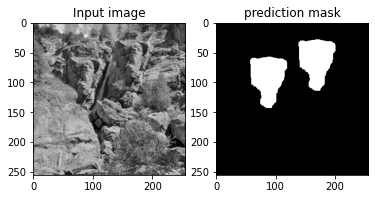

In [8]:
## CREATE PREDICTION MASK

print("painting mask starting...")

for i in range(0, sim_array.shape[0]):
    index1 = int(sim_array[i][0])
    index2 = int(sim_array[i][1])
    index3 = int(sim_array[i][2])
    index4 = int(sim_array[i][3])
    for j in range(0, block_size - 1):
        for k in range(0, block_size - 1):
            ############# EDIT HERE #############
            ## paint the matching blocks in white
            prediction_mask[index1+j][index2+k]=255
            prediction_mask[index3+j][index4+k]=255  
            ############# EDIT END #############

print("painting mask over!")

fig, axs = plt.subplots(1, 2)
axs[0].set_title('Input image')
axs[0].imshow(gray, cmap='gray', vmin=0, vmax=255)

axs[1].set_title('prediction mask')
axs[1].imshow(prediction_mask, cmap='gray', vmin=0, vmax=255)

plt.show()

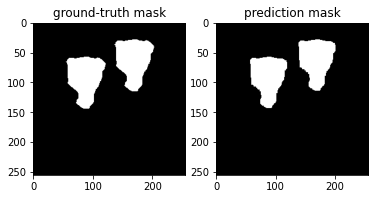

accuracy calculating...
Accuracy: 0.9673316374347302
accuracy calculated!


In [9]:
## If you have the ground-truth mask, you can test the detection accuracy with the code below

############# EDIT HERE #############
## read the ground-truth mask image
mask = cv2.imread("/content/ImSecu/ValidationSet/image103_ground_truth_mask.jpg")
############# EDIT END #############

width, height, channels = mask.shape
if width > 256 | height > 256:
    mask = cv2.resize(mask, resize_dim, interpolation = cv2.INTER_AREA)
mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
arr = np.array(gray)
mask = np.array(mask_gray)

fig, axs = plt.subplots(1, 2)
axs[0].set_title('ground-truth mask')
axs[0].imshow(mask, cmap='gray', vmin=0, vmax=255)

axs[1].set_title('prediction mask')
axs[1].imshow(prediction_mask, cmap='gray', vmin=0, vmax=255)

plt.show()

print("accuracy calculating...")

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(0, prediction_mask.shape[0]):
    for j in range(0, prediction_mask.shape[1]):
        if prediction_mask[i][j] == mask[i][j]:
            if prediction_mask[i][j] == 255:
                TP += 1
            else:
                TN += 1
        else:
            if prediction_mask[i][j] == 255:
                FP += 1
            else:
                FN += 1

if TP == 0 and FN == 0:
    accuracy = TN/(TN+FP)
else:
    recall = TP/(TP+FN)
    if TP != 0:
      precision = TP/(TP+FP)
      accuracy = 2*precision*recall/(precision+recall)
    else:
      accuracy = recall

print('Accuracy:', accuracy)

print("accuracy calculated!")



---


# **Optional problem (if time permits):**

After studying how the DCT-based image forgery detection method works, would you be able to: 

1.   create a copy-move manipulated image so that the detection accuracy is greatly reduced (but not 0)? How? (max 10 lines)
2.   create a copy-move manipulated image so that the algorithm cannot detect the change? How? (max 10 lines)

Provide the manipulated image(s) and the corresponding prediction mask(s) in a folder named "optional_problem" along with the other files in the submission zip file.

**Rules:** you actually have to make a copy-move modification, so you have to copy a part of the image into the image itself. But you are allowed to apply other processing.

---



# Tips

If you have unexpected errors while running the code, try to restart the runtime: *Menu bar -> Runtime -> Restart runtime*

If you have questions about the challenge, you can ask them on **Moodle** where a specific topic will be opened in the **forum**.